In [35]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from iflow.dataset import gen_cycle_dataset
from data.human_robot_interaction_data.read_hh_hr_data import read_data
#from iflow.dataset.iros_dataset import IROS

import torch
import torch.optim as optim
from iflow.dataset import drums_dataset, gen_cycle_dataset, hr_cycle_dataset, hr_vel_cycle_dataset
from torch.utils.data import DataLoader
from iflow import model
from iflow.trainers import cycle_dynamics_train
from iflow.utils.generic import to_torch
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

from iflow.visualization import visualize_vector_field, visualize_trajectories
from iflow.test_measures.log_likelihood import cycle_log_likelihood

In [2]:
batch_size = 100
depth_h = 3
depth_r = 3
## training variables ##

device = torch.device('cpu')

def main_layer(dim):
    return  model.ResNetCouplingLayer(dim)

def create_flow_seq(dim, depth):
    chain = []
    for i in range(depth):
        chain.append(main_layer(dim))
        chain.append(model.Permutation(torch.tensor([1,0, 2,3], dtype=torch.int32),1))
        chain.append(model.LULinear(dim))
    chain.append(main_layer(dim))
    return model.SequentialFlow(chain)

In [3]:
data_p1_p, data_p1_q, names_p1, times_p1 = read_data('data/human_robot_interaction_data/hh/p1/hand_shake_s1_1.csv')
data_p2_p, data_p2_q, names_p2, times_p2 = read_data('data/human_robot_interaction_data/hh/p2/hand_shake_s2_1.csv')
segments = np.load('data/human_robot_interaction_data/hh/segmentation/hand_shake_1.npy')

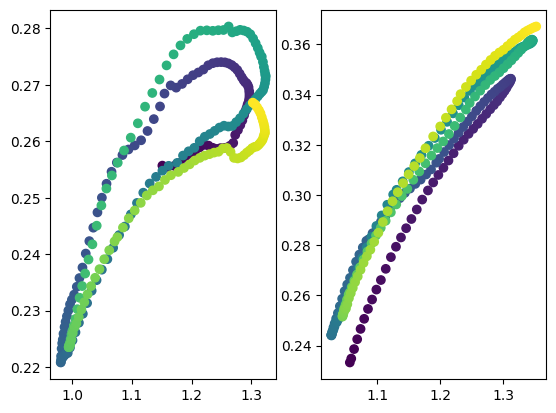

In [4]:
trajs_p1 = [data_p1_p[s[0]:s[1], :, :] for s in segments]
trajs_p2 = [data_p2_p[s[0]:s[1], :, :] for s in segments]

# downsample
stepsize = 1
cutoff = 400
offset = 140

trajs_p1_downsampled = np.array([a[::stepsize,:,:][offset:cutoff] for a in trajs_p1])
trajs_p1 = trajs_p1_downsampled.reshape(19,cutoff-offset,26*3)[:,:,-2:]

trajs_p2_downsampled = np.array([a[::stepsize,:,:][offset:cutoff] for a in trajs_p2])
trajs_p2 = trajs_p2_downsampled.reshape(19,cutoff-offset,26*3)[:,:,-2:]

dim_p1 = 2+2
dim_p2 = 2+2

trajs_p2 = trajs_p2[1:2]
trajs_p1 = trajs_p1[1:2]

plt.subplot(121)
for i in range(len(trajs_p1)):
    plt.scatter(trajs_p1[i,:,0],trajs_p1[i,:,1], c=np.arange(cutoff-offset))

a = np.arange(cutoff-offset)
plt.subplot(122)
for i in range(len(trajs_p2)):
    plt.scatter(trajs_p2[i,:,0],trajs_p2[i,:,1], c=a)

In [5]:
from iflow.dataset import gen_cycle_dataset
d1 = gen_cycle_dataset.GENCYCLE(trajs_p1, 2)
d2 = gen_cycle_dataset.GENCYCLE(trajs_p2, 2)

In [6]:
d1.w, d2.w

(4.8706862846353385, 12.176715711588345)

In [7]:
vel_p1 = np.diff(trajs_p1, axis=1, prepend=trajs_p1[:1,:1,:])
vel_p2 = np.diff(trajs_p2, axis=1, prepend=trajs_p2[:1,:1,:])
trajs_vel_p1 = np.concatenate([trajs_p1, vel_p1], axis=2)
trajs_vel_p2 = np.concatenate([trajs_p2, vel_p2], axis=2)
data = hr_cycle_dataset.HRCycleDataset(trajs_vel_p1, trajs_vel_p2, dim_p1, dim_p2)

In [8]:
data.w

4.8706862846353385

In [9]:
T_period = (2*np.pi)/data.w
params = {'batch_size': batch_size, 'shuffle': True}
dataloader = DataLoader(data, **params)

In [10]:
x,y = next(iter(dataloader))
x[0].shape

torch.Size([100, 4])

In [11]:
x[0].shape

torch.Size([100, 4])

In [12]:
dim_p1, dim_p2

(4, 4)

In [13]:
def hr_cycle_dynamics_train(iflow, x, y):
    ## Separate Data ##
    y0 = x
    y1 = y[0]
    step = y[1][0]
    phase = y[2]
    ## Evolve dynamics forward ##
    x1_h, x1_r, log_det_J_x1_h, log_det_J_x1_r = iflow(y1)
    x0_h, x0_r, log_det_J_x0_h, log_det_J_x0_r = iflow(y0)

    x1 = torch.cat([x1_h, x1_r], dim=1)
    x0 = torch.cat([x0_h, x0_r], dim=1)

    ### Forward Conditioning ###
    log_p_z1 = iflow.dynamics.cartesian_cond_log_prob(x0, x1, T=step)
    log_trj = log_p_z1 + log_det_J_x1_h.squeeze() + log_det_J_x1_r.squeeze()

    ### Stable Point ###
    log_p_z0 = iflow.dynamics.stable_log_prob(x0, ref_phase=phase)
    log_stable = log_p_z0 + log_det_J_x0_h.squeeze() + log_det_J_x0_r.squeeze()

    log_total = torch.mean(log_stable) + torch.mean(log_trj)
    return -log_total

In [48]:
def train(depth, weight_decay=0.1, lr=0.001, nr_epochs=10_000, plotting=True, early_stopping=False):

    lsd = model.HRLinearLimitCycle(dim_p1, dim_p2, device, dt=data.dt, T_period=T_period).to(device)
    flow_human = create_flow_seq(dim_p1, depth).to(device)
    flow_robot = create_flow_seq(dim_p2, depth).to(device)
    iflow = model.HumanRobotFlow(dynamics=lsd, model_human=flow_human,
                                 model_robot=flow_robot).to(device)

    params = list(flow_human.parameters()) + list(flow_robot.parameters()) + list(lsd.parameters())
    optimizer = optim.Adam(params, lr = lr, weight_decay= weight_decay)

    likelihood_hist = []
    steps_hist = []

    for i in range(nr_epochs):
        # Training
        for local_x, local_y in dataloader:
            dataloader.dataset.set_step()
            optimizer.zero_grad()
            loss = hr_cycle_dynamics_train(iflow, local_x, local_y)
            loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_norm_(parameters=iflow.parameters(), max_norm=10, norm_type=2.0)
            optimizer.step()

        if early_stopping:
            with torch.no_grad():
                iflow.eval()
                likelihood = loss.detach().item()
                print(likelihood)
                likelihood_hist.append(likelihood)
                steps_hist.append(i)
                if likelihood < 12:
                    break
                else:
                    continue

        ## Validation ##
        if i%100 == 0:
            with torch.no_grad():
                iflow.eval()
                likelihood = loss.detach().item()
                print(likelihood)
                likelihood_hist.append(likelihood)
                steps_hist.append(i)
                if not plotting:
                    continue

                # plotting
                y0 = torch.from_numpy(data.train_data[0][0][None, :]).float().to(device)
                y0_h = y0[:, :dim_p1]
                y0_r = y0[:, dim_p1:]

                trj_h, trj_r = iflow.generate_trj(y0_h, y0_r, T=400)
                trj_h = trj_h.detach().cpu().numpy()
                trj_r = trj_r.detach().cpu().numpy()

                plt.figure(figsize=(10,5))
                plt.subplot(121)
                for t in data.train_data[:, :, :data.dim_h]:
                    plt.plot(t[:,0], t[:,1])

                plt.plot(trj_h[:,0], trj_h[:,1], 'r')

                plt.subplot(122)
                for t in data.train_data[:, :, data.dim_h:]:
                    plt.plot(t[:,0], t[:,1])
                plt.plot(trj_r[:,0], trj_r[:,1], 'r')

                plt.show()
    return likelihood_hist, steps_hist

In [34]:
mean_squared_error(data.train_data[:, :, :data.dim_h][0], data.train_data[:, :, data.dim_h:][0])

0.7467537103040014

In [30]:
data.train_data[:, :, :data.dim_h][0]

array([[-0.15573594,  0.07247299, -0.08746999, -0.03655516],
       [-0.0781063 ,  0.05978329,  1.30962612, -0.22153707],
       [ 0.01252431,  0.06970954,  1.54360399,  0.10814295],
       ...,
       [ 1.16840742,  0.67613972, -0.5465481 ,  0.40290465],
       [ 1.13977183,  0.70655529, -0.60282316,  0.40682232],
       [ 1.10793406,  0.72446811, -0.66045243,  0.22456573]])

In [29]:
data.train_data[:, :, data.dim_h:][0]

array([[-1.21008019, -1.92867379, -0.18334584, -0.21379118],
       [-1.18839369, -1.88872818,  0.183566  ,  0.43415535],
       [-1.14579044, -1.79207691,  0.53745423,  1.35396203],
       ...,
       [ 1.54851531,  1.48133572,  0.41783004, -0.01023864],
       [ 1.58005672,  1.49124021,  0.35030025, -0.05313333],
       [ 1.60747371,  1.49815978,  0.28051947, -0.10155076]])

In [20]:
lh, sh = [], []
depths = [1, 5, 10, 100]
for d in depths:
    likelihood_hist, steps_hist = train(d, weight_decay=0.1, lr=0.001, nr_epochs=1_000, plotting=False, early_stopping=False)
    lh.append(likelihood_hist)
    sh.append(steps_hist)

1833.3919677734375
208.6848907470703
117.83283233642578
59.770896911621094
31.68996238708496
51.362361907958984
40.33247375488281
52.47199249267578
27.601409912109375
25.372936248779297
2385.071533203125
124.74967193603516
87.21572875976562
57.64650344848633
21.06272315979004
25.331083297729492
19.200908660888672
21.89043426513672
22.939308166503906
25.772930145263672
2540.64013671875
68.77458190917969
40.39329528808594
20.748676300048828
26.102779388427734
23.389598846435547
23.695331573486328
17.51380157470703
20.0106201171875
16.497024536132812
334.0531005859375
47.54627990722656
38.08170700073242
32.85297775268555
26.192604064941406
22.048410415649414
16.167943954467773
20.12579345703125
13.960838317871094
13.625917434692383


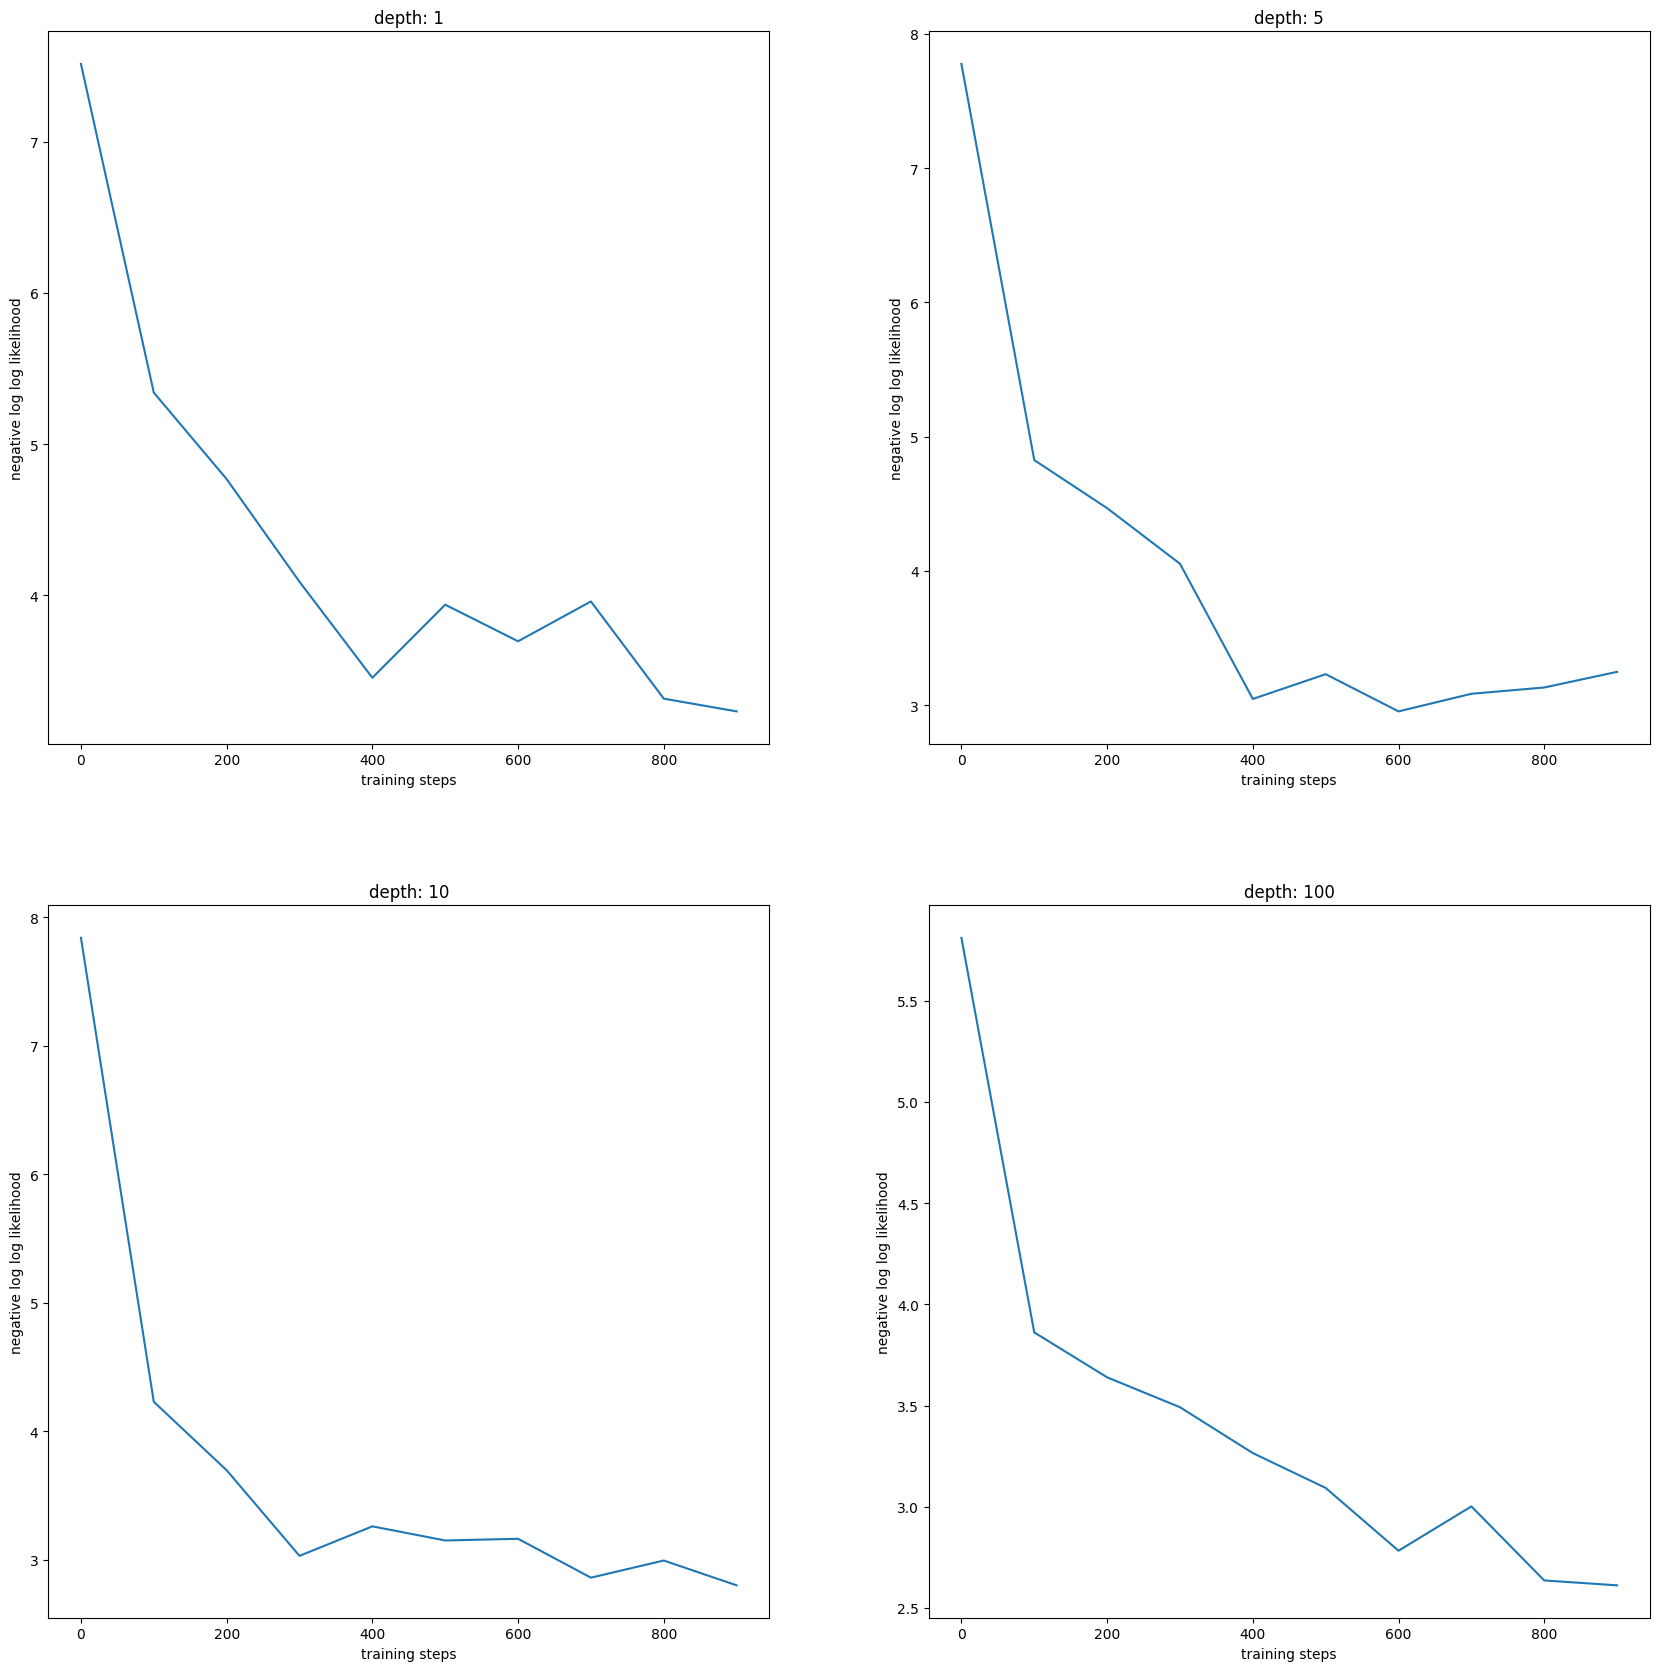

In [23]:
%matplotlib inline
fig, axs = plt.subplots(2,2)
fig.tight_layout(pad=1)
fig.set_size_inches(18, 18)
for i in range(2):
    for j in range(2):
        axs[i][j].set_title(f"depth: {depths[i*2+j]}")
        axs[i][j].set_xlabel("training steps")
        axs[i][j].set_ylabel("negative log log likelihood")
        axs[i][j].plot(sh[i+j], np.log(lh[i*2+j]))


In [49]:
from tqdm import tqdm

lh, sh = [], []
params = []
lrs = [0.001, 0.005, 0.01]
wdecs = [0, 0.1, 0.5, 1]

for lr in tqdm(lrs):
    for w in tqdm(wdecs):
        for i in range(1):
            likelihood_hist, steps_hist = train(5, weight_decay=w, lr=lr, nr_epochs=3_000, plotting=True, early_stopping=True)
            lh.append(likelihood_hist)
            sh.append(steps_hist)
            params.append({"lr":lr, "w":w})

  0%|          | 0/4 [00:00<?, ?it/s]

2400.36669921875
1867.2213134765625
1469.4261474609375
1380.798095703125
822.7573852539062
1001.580078125
875.8904418945312
749.2390747070312
350.58038330078125
666.3131103515625
613.689697265625
422.3021240234375
377.9391784667969
551.5338745117188
351.0707702636719
346.10791015625
255.893798828125
411.877197265625
158.6959228515625
368.3702087402344
342.0301818847656
333.4527587890625
185.3160858154297
336.4170837402344
277.52886962890625
248.76173400878906
259.89300537109375
195.53469848632812
125.34451293945312
142.72796630859375
229.53472900390625
223.08615112304688
248.6008758544922
130.15411376953125
247.64642333984375
238.8204345703125
110.83346557617188
254.58238220214844
201.9381103515625
119.74986267089844
142.69479370117188
84.8563232421875
216.28643798828125
249.15184020996094
178.67958068847656
93.2408447265625
173.14630126953125
216.69187927246094
182.81756591796875
152.2384796142578
155.45199584960938
217.181884765625
173.4279327392578
86.70652770996094
89.8427276611328


 25%|██▌       | 1/4 [00:41<02:04, 41.54s/it]

8.737066268920898
2299.57470703125
1459.7578125
1399.968017578125
1173.655029296875
912.4760131835938
953.4594116210938
715.1322631835938
774.5771484375
678.54296875
604.3220825195312
471.2545166015625
272.3963317871094
481.1531066894531
495.96307373046875
436.6603698730469
435.29412841796875
130.8946533203125
243.28421020507812
104.60665130615234
277.4400634765625
172.41131591796875
113.68376159667969
101.84133911132812
332.3629150390625
92.65399932861328
137.93617248535156
280.63726806640625
277.02227783203125
291.68988037109375
205.59242248535156
66.41473388671875
151.434814453125
256.0604553222656
127.36840057373047
234.2822265625
228.62387084960938
202.7079315185547
113.2022476196289
210.39439392089844
153.92796325683594
228.11422729492188
222.57276916503906
134.73170471191406
192.67515563964844
217.45697021484375
170.87355041503906
230.17672729492188
207.0312042236328
125.68309020996094
194.0539093017578
77.78902435302734
169.4989471435547
145.8946990966797
125.33050537109375
118


 50%|█████     | 2/4 [01:24<01:25, 42.57s/it]

17.895479202270508
20.739837646484375
27.81377410888672
9.801816940307617
1145.5133056640625
899.3577880859375
1128.2105712890625
1099.49755859375
802.0399169921875
688.85302734375
257.4601135253906
815.5784301757812
523.7581176757812
692.85107421875
586.6682739257812
181.54713439941406
497.7230529785156
505.06292724609375
507.42547607421875
387.6007080078125
111.7635498046875
97.79096221923828
406.8000183105469
261.9476013183594
180.87339782714844
183.2386932373047
212.95980834960938
302.6280212402344
260.964599609375
303.071044921875
180.2330780029297
195.6019287109375
136.57623291015625
111.65415954589844
260.1805419921875
208.1017303466797
213.74591064453125
110.24076843261719
247.62734985351562
131.93141174316406
143.73399353027344
241.37832641601562
225.82510375976562
133.2722930908203
122.87873840332031
205.53346252441406
95.35016632080078
90.13890075683594
124.7928466796875
141.693603515625
245.2206573486328
235.64051818847656
256.5237121582031
180.0478057861328
191.52429199218


 75%|███████▌  | 3/4 [02:05<00:41, 41.55s/it]

42.104347229003906
23.784862518310547
39.988868713378906
20.710826873779297
5.655914306640625
1407.9107666015625
1057.4573974609375
1946.779541015625
1288.5322265625
527.349365234375
884.1882934570312
468.7301025390625
744.3568725585938
791.4885864257812
688.1355590820312
323.5328063964844
484.86041259765625
500.94976806640625
539.473876953125
383.75238037109375
332.85430908203125
407.28851318359375
320.26763916015625
338.6236572265625
261.3279724121094
184.05543518066406
151.22618103027344
186.19915771484375
126.25028228759766
195.96914672851562
81.93445587158203
169.77447509765625
89.31953430175781
277.0947265625
264.6545715332031
179.72177124023438
256.9491882324219
176.15834045410156
110.5732421875
131.01361083984375
150.04986572265625
122.39579772949219
196.03936767578125
234.50643920898438
130.21881103515625
98.52355194091797
41.41297912597656
186.2139129638672
132.5476837158203
176.13922119140625
190.83132934570312
162.37123107910156
169.35116577148438
124.97622680664062
149.961


 33%|███▎      | 1/3 [03:33<07:07, 213.93s/it]

11.271459579467773



  0%|          | 0/4 [00:00<?, ?it/s]

977.114990234375
410.90643310546875
89.11543273925781
500.3180847167969
97.87832641601562
120.60270690917969
105.57450866699219
261.3309020996094
170.06643676757812
205.45753479003906
212.1695098876953
213.57546997070312
115.36241149902344
136.09542846679688
141.05596923828125
160.70140075683594
76.07378387451172
124.52035522460938
141.24920654296875
230.2577667236328
133.41268920898438
222.7284698486328
148.72508239746094
96.76713562011719
104.56340789794922
235.01052856445312
172.44593811035156
83.96507263183594
167.90489196777344
147.54647827148438
129.19049072265625
175.42208862304688
96.6651840209961
124.50502014160156
80.98419189453125
70.07199096679688
96.84284210205078
93.44972229003906
84.8593978881836
106.9659423828125
95.28651428222656
138.1283416748047
125.29364013671875
121.20277404785156
79.6540298461914
88.49122619628906
91.7981948852539
122.07093811035156
74.9404296875
92.20767211914062
44.635826110839844
100.08263397216797
65.20867919921875
123.30589294433594
76.103965


 25%|██▌       | 1/4 [00:22<01:07, 22.53s/it]

34.405155181884766
21.38941192626953
10.216230392456055
1048.5987548828125
722.5802612304688
298.8242492675781
364.24212646484375
239.43252563476562
350.2002868652344
281.9432373046875
255.979736328125
221.35350036621094
135.0236358642578
179.29100036621094
224.6159210205078
170.5751495361328
121.03522491455078
67.48250579833984
169.4293670654297
155.1937255859375
98.94452667236328
127.70660400390625
71.28224182128906
134.75250244140625
151.4097900390625
103.89688110351562
84.38330841064453
96.45968627929688
128.11305236816406
80.81304931640625
70.04691314697266
131.47714233398438
126.82381439208984
83.32339477539062
49.53962707519531
80.88014221191406
90.6160888671875
63.23748016357422
98.52273559570312
113.01746368408203
71.78533935546875
92.33683776855469
78.91209411621094
38.78180694580078
63.075721740722656
49.35581970214844
56.13243865966797
78.3831787109375
59.23265075683594
49.95255661010742
56.6981086730957
78.42787170410156
60.73369598388672
64.78620910644531
69.4779739379882


 50%|█████     | 2/4 [00:38<00:37, 18.85s/it]

24.881084442138672
18.982463836669922
11.252629280090332
1393.78955078125
753.2258911132812
239.32408142089844
399.3396911621094
324.4515686035156
369.3468017578125
108.09828186035156
187.92831420898438
208.80712890625
217.19029235839844
106.0533676147461
258.0057678222656
124.67568969726562
192.5968475341797
205.93429565429688
97.4783706665039
164.80052185058594
100.22744750976562
119.403076171875
193.70632934570312
96.99771881103516
118.31658935546875
168.9285125732422
82.67733764648438
92.40174102783203
94.7857666015625
47.58766174316406
95.50497436523438
127.33030700683594
135.56744384765625
75.66234588623047
155.89886474609375
71.62577056884766
124.99043273925781
78.83572387695312
62.719146728515625
128.00596618652344
122.59431457519531
93.97785186767578
81.72835540771484
128.67147827148438
144.54786682128906
52.677207946777344
90.11473083496094
67.63035583496094
71.35360717773438
123.18980407714844
102.13788604736328
59.50461959838867
67.81929016113281
87.27439880371094
58.451221


 75%|███████▌  | 3/4 [00:57<00:18, 18.99s/it]

8.056577682495117
569.444091796875
618.4999389648438
704.140380859375
517.1414794921875
335.1557922363281
324.49755859375
132.99981689453125
355.2293701171875
291.51751708984375
121.91671752929688
142.7349853515625
256.3530578613281
206.46302795410156
134.59922790527344
262.58831787109375
85.09495544433594
231.11451721191406
234.8174591064453
89.41661834716797
189.5775909423828
198.4438018798828
115.17593383789062
132.2611541748047
145.5404052734375
47.62543487548828
130.55816650390625
92.46788787841797
113.59275817871094
90.25972747802734
153.1007537841797
161.5169677734375
133.9487762451172
126.93062591552734
65.86253356933594
85.00604248046875
68.89249420166016
117.88560485839844
101.3138198852539
146.78118896484375
117.08562469482422
75.58953094482422
33.887332916259766
135.52586364746094
80.80223083496094
60.56887435913086
69.60151672363281
106.65040588378906
134.08116149902344
77.14527893066406
20.490921020507812
23.800582885742188
47.17510223388672
65.65798950195312
28.856834411


 67%|██████▋   | 2/3 [04:49<02:12, 132.71s/it]

14.07431697845459
25.593555450439453
5.234601020812988



  0%|          | 0/4 [00:00<?, ?it/s]

940.2453002929688
591.200439453125
290.4864196777344
245.94110107421875
309.8367614746094
330.13037109375
313.6346130371094
220.19166564941406
155.4077911376953
313.8389587402344
150.36476135253906
83.25726318359375
122.84375762939453
136.72227478027344
239.3629150390625
147.4004364013672
108.75733947753906
94.7445297241211
80.56352233886719
48.95348358154297
67.31830596923828
99.27239990234375
88.66233825683594
52.2417106628418
109.00177001953125
111.28983306884766
81.93122863769531
103.84590148925781
74.3915023803711
58.44609451293945
74.68025207519531
57.48430633544922
37.23081970214844
76.07305145263672
45.891639709472656
66.07135772705078
59.11786651611328
62.88825225830078
57.09833526611328
58.20569610595703
59.85298156738281
53.60159683227539
60.60691833496094
66.51837158203125
60.14751434326172
47.68998336791992
55.471038818359375
57.573665618896484
54.530303955078125
48.91455841064453
70.52277374267578
53.23305892944336
48.31448745727539
43.29607391357422
82.07417297363281
45.


 25%|██▌       | 1/4 [00:12<00:38, 12.84s/it]

42.07048797607422
11.028124809265137
775.3165283203125
474.48602294921875
320.11114501953125
305.7201843261719
261.9986572265625
127.73054504394531
229.6790313720703
170.2342529296875
163.42355346679688
130.4185333251953
167.51104736328125
206.27731323242188
118.31926727294922
170.57949829101562
166.79031372070312
119.23789978027344
88.92880249023438
48.67731857299805
113.47732543945312
49.764793395996094
153.2432861328125
72.41630554199219
62.17644119262695
131.25076293945312
109.8980712890625
126.31674194335938
96.60284423828125
108.13753509521484
67.5538330078125
76.43992614746094
85.66444396972656
65.38591003417969
55.56797790527344
79.0508041381836
87.18931579589844
55.31315231323242
64.10501861572266
89.48683166503906
79.63298797607422
50.02608108520508
64.16191864013672
80.68960571289062
44.25468444824219
37.487403869628906
52.50349426269531
54.645668029785156
42.95506286621094
60.630165100097656
57.56959533691406
67.40803527832031
56.06639099121094
52.24806213378906
104.2803955


 50%|█████     | 2/4 [00:24<00:24, 12.03s/it]

19.420732498168945
17.623737335205078
11.836408615112305
760.3851928710938
317.48016357421875
142.10768127441406
329.81585693359375
318.54345703125
261.26190185546875
170.7209014892578
155.42120361328125
292.8856506347656
152.64385986328125
79.22091674804688
184.32833862304688
187.6023406982422
118.57844543457031
217.47598266601562
95.89485168457031
85.08583068847656
137.8765869140625
88.24479675292969
82.62716674804688
152.35890197753906
87.95128631591797
106.16749572753906
79.0521011352539
102.1742935180664
106.4649887084961
95.80609130859375
87.43765258789062
44.01648712158203
77.13169860839844
53.69654083251953
110.58489990234375
71.91230773925781
54.188594818115234
43.56249237060547
44.57472610473633
108.6165771484375
72.21158599853516
74.20032501220703
52.24847412109375
181.6269073486328
96.42859649658203
64.16043090820312
26.767303466796875
53.37052536010742
63.393009185791016
47.49716567993164
70.98158264160156
69.25263977050781
67.43465423583984
47.73790740966797
61.3485260009


 75%|███████▌  | 3/4 [00:33<00:10, 10.74s/it]

9.167181015014648
329.1596374511719
179.0744171142578
268.6531677246094
150.02088928222656
109.15129089355469
341.374755859375
162.1138458251953
270.5564270019531
193.81744384765625
247.16189575195312
176.32167053222656
142.2805633544922
164.50881958007812
100.74740600585938
126.29823303222656
152.23147583007812
78.16671752929688
150.9286651611328
83.50614166259766
72.44020080566406
67.36922454833984
42.80797576904297
161.31936645507812
109.6463623046875
82.00180053710938
83.04256439208984
128.80250549316406
98.17253112792969
94.8519287109375
58.663265228271484
74.13807678222656
57.50335693359375
84.7291030883789
75.00261688232422
56.800682067871094
89.29438018798828
121.37295532226562
46.50994110107422
74.64749908447266
51.482032775878906
100.94562530517578
46.48310089111328
42.63676452636719
54.49336242675781
60.22394561767578
94.6357421875
58.0252799987793
73.53414916992188
67.88392639160156
55.71680450439453
57.74560546875
53.32984924316406
50.58275604248047
49.58747100830078
54.66


100%|██████████| 3/3 [05:31<00:00, 110.34s/it]

28.672439575195312
28.593246459960938
11.771526336669922


In [55]:
for i, _ in enumerate(sh):

    print(len(sh[i]), params[i])

883 {'lr': 0.001, 'w': 0}
914 {'lr': 0.001, 'w': 0.1}
861 {'lr': 0.001, 'w': 0.5}
921 {'lr': 0.001, 'w': 1}
296 {'lr': 0.005, 'w': 0}
235 {'lr': 0.005, 'w': 0.1}
281 {'lr': 0.005, 'w': 0.5}
259 {'lr': 0.005, 'w': 1}
213 {'lr': 0.01, 'w': 0}
201 {'lr': 0.01, 'w': 0.1}
165 {'lr': 0.01, 'w': 0.5}
131 {'lr': 0.01, 'w': 1}
